# IA Generativa: Dibuja nuevas formas tomando como base dibujos a mano alzada
## ¿Podemos hacer que una IA dibuje nuevas formas a partir de otros dibujos?
La respuesta es: ¡Claro!
En este ejercicio se creará una GAN (Generative Adversarial Network)
¿Qué es una GAN?
Las GAN son un modelo donde se presentan dos adversarios, un generador y un
discriminador.
En generador intentara convertir entradas “aleatorias” en objetos parecidos a los del
dataset original
El discriminador intentará predecir si un objeto es en realidad del dataset original o si ha
sido generado.
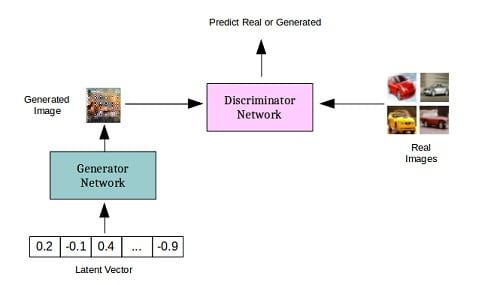

In [2]:
from tensorflow import keras
from keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Dropout, BatchNormalization, UpSampling2D, LeakyReLU
from keras.models import Model
from keras import backend as K
from keras.optimizers import Adam, RMSprop
from keras.losses import binary_crossentropy
from keras.callbacks import ModelCheckpoint

import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
import glob

2023-08-20 03:09:22.918431: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-20 03:09:24.069674: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-20 03:09:24.069760: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-08-20 03:09:24.069772: W 

# Comenzamos con la creación de la GAN
## ¿Cómo funciona?
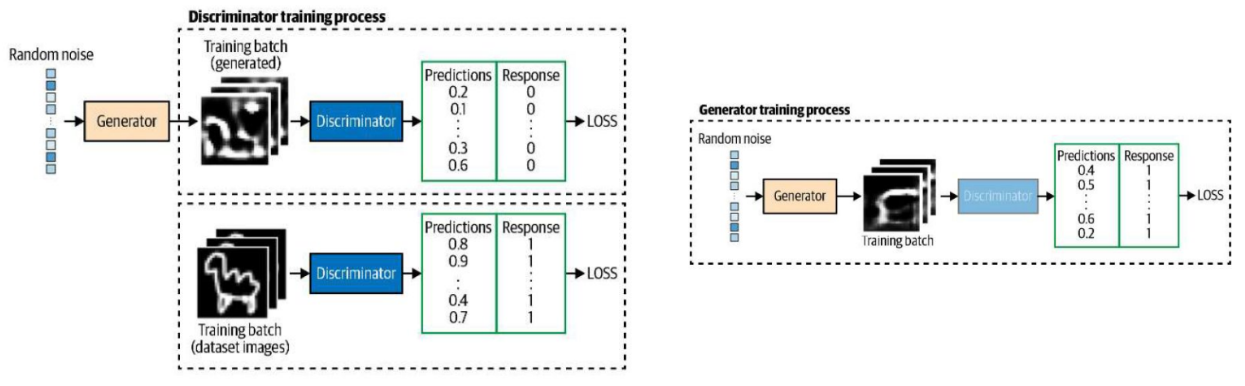

Se crearán 2 modelos, 1 Generador y 1 Discriminador. El discriminador pasará por 2 procesos: primero se le entrenará ingresando un DataSet real que siempre calificará como 1 (valor máximo) y como segunda etapa se le entrena ingresando las imágenes generadas por ruido que calificará como cercanos a 0 (mínimo). Ahora sabrá diferenciar entre lo que está bien y lo que está mal, por lo que el tercer proceso es el entrenamiento del generador con la calificación realista del discriminador, lo cual, sí genera ruido de más, el discriminador lo calificará como cercano a cero, cuando genere cercano al DataSet, el discriminador calificará como cercano a 1, por lo que las pérdidas son menores y el generador estará cerca de generar al DataSet real.


In [3]:
# Cargar las primeras imagenes y observarlas

skull = np.load('RedHat.npy')  #Cargar la base de datos dependiendo del ambiente de trabajo

222610


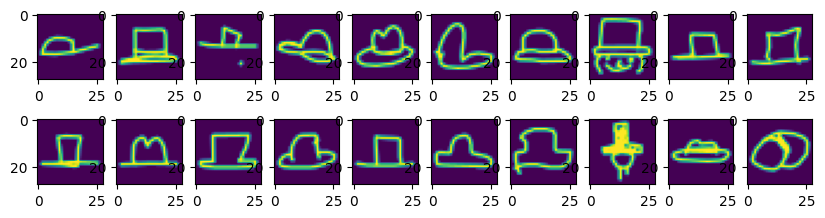

(222610, 28, 28)

In [4]:
#Ver algunos ejemplos de las imagenes
print(len(skull))  # Debe imprimir el tamaño de la base de datos

img = plt.figure(figsize=(10,2.5))
for i in range(20):
  skull1 = np.reshape(skull[i],(28,28))
  ax = img.add_subplot(2, 10, i+1)
  ax.imshow(skull1)

plt.show()

# Tratar los datos para su uso en una red

skull2 = []
for j in range(skull.shape[0]):
  skull2.append(np.reshape(skull[j],(28,28)))

np.array(skull2)
np.shape(skull2)

# Generar el modelo de VAE

In [6]:
# Definir el modelo del variational autoencoder
input_size = (28,28,1)
latent_dim = 100
d_p = 0.3

#Discriminador
x = Input(input_size)
conv1 = Conv2D(64,5,strides=(2,2),padding='same',activation=LeakyReLU(alpha=0.2))(x)
conv1 = Dropout(d_p)(conv1)

conv2 = Conv2D(64,5,strides=(2,2),padding='same',activation=LeakyReLU(alpha=0.2))(conv1)
conv2 = Dropout(d_p)(conv2)

conv3 = Conv2D(128,5,strides=(2,2),padding='same',activation=LeakyReLU(alpha=0.2))(conv2)
conv3 = Dropout(d_p)(conv3)

conv4 = Conv2D(128,5,strides=(1,1),padding='same',activation=LeakyReLU(alpha=0.2))(conv3)
conv4 = Dropout(d_p)(conv4)

f = Flatten()(conv4)
d1 = Dense(1, activation='sigmoid')(f)



#Generador
g_x = Input(shape=(latent_dim))
d = Dense(3136)(g_x)
d = BatchNormalization()(d)
r = Reshape((7,7,64))(d)

dec1 = UpSampling2D(size=(2,2))(r)
dec1 = Conv2D(128,5,strides=(1,1), padding='same', activation=LeakyReLU(alpha=0.2))(dec1)
dec1 = BatchNormalization(momentum=0.8)(dec1)

dec2 = UpSampling2D(size=(2,2))(dec1)
dec2 = Conv2D(64,5,strides=(1,1), padding='same', activation=LeakyReLU(alpha=0.2))(dec2)
dec2 = BatchNormalization(momentum=0.8)(dec2)

dec3 = Conv2D(64,5,strides=(1,1), padding='same', activation=LeakyReLU(alpha=0.2))(dec2)
dec3 = BatchNormalization(momentum=0.8)(dec3)

dec4 = Conv2D(1,5,strides=(1,1), padding='same', activation='tanh')(dec3)

In [7]:
# Compilar los modelos

opti = Adam(0.0002, 0.5)

# Definir discriminador y generador
discriminador = Model(x, d1, name= 'discriminador')
discriminador.compile(optimizer=opti, loss='binary_crossentropy', metrics=['accuracy'])
discriminador.summary()

generador = Model(g_x, dec4, name='generador')
generador.summary()

# Modelo combinado
discriminador.trainable = False
sal_dis = discriminador(generador(g_x))
modelo_t = Model(g_x, sal_dis)
modelo_t.compile(optimizer=opti, loss='binary_crossentropy', metrics=['accuracy'])
modelo_t.summary()

Model: "discriminador"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_8 (Conv2D)           (None, 14, 14, 64)        1664      
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 conv2d_9 (Conv2D)           (None, 7, 7, 64)          102464    
                                                                 
 dropout_5 (Dropout)         (None, 7, 7, 64)          0         
                                                                 
 conv2d_10 (Conv2D)          (None, 4, 4, 128)         204928    
                                                                 
 dropout_6 (Dropout)         (None, 4, 4, 128)       

In [1]:
# Se necesita entrenar en dos partes

# Primero el discriminador para que diferencia imagenes reales de ruido

# Con ayuda del discriminador se entrena el generador
def train(epochs, batch_size=128, sample_interval=50):#
        X_train= np.array(skull2)
        X_train = X_train / 127.5 - 1.
        X_train = np.expand_dims(X_train, axis=-1)

        valid = np.ones((batch_size, 1))   # Tomar los valores como reales
        fake = np.zeros((batch_size, 1))   # Tomar los valores como falsos

        for epoch in range(epochs):
            idx = np.random.randint(0, X_train.shape[0], batch_size) # Escoje numero aleatoriamente
            imgs = X_train[idx]                                      # Toma idx imagenes reales

            noise = np.random.normal(0, 1, (batch_size, latent_dim)) # crea ruidos aleatorios

            gen_imgs = generador.predict(noise)                      # Crea objetos falsos

            #discriminador.trainable = True
            d_loss_fake = discriminador.train_on_batch(gen_imgs, fake) # Observa los objetos falsos
            d_loss_real = discriminador.train_on_batch(imgs, valid)  # Observa los objetos reales
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)            # Junta las dos perdidas del discriminador

            #discriminador.trainable = False
            noise = np.random.normal(0, 1, (batch_size, latent_dim))
            g_loss = modelo_t.train_on_batch(noise, valid)           # Observa la perdida del modelo total

            print ('Epoca: ',epoch, '  D_loss: ', round(d_loss[0],3), '  G_loss: ', round(g_loss[0],3), '  D_loss_real: ', round(d_loss_real[0],3))
            if epoch % sample_interval == 0:
              sample_images(epoch)

def sample_images(epoch):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, latent_dim))
        gen_imgs = generador.predict(noise)
        gen_imgs = 0.5 * gen_imgs + 0.5
        fig, axs = plt.subplots(r, c)
        cnt = 0
        for i in range(r):
            for j in range(c):
                axs[i, j].imshow(gen_imgs[cnt, :, :, 0], cmap='gray')
                axs[i, j].axis('off')
                cnt += 1
        plt.show()

train(epochs=110, batch_size=64, sample_interval=100)   #128

NameError: name 'np' is not defined

1/1 [==============================] - 0s 94ms/step


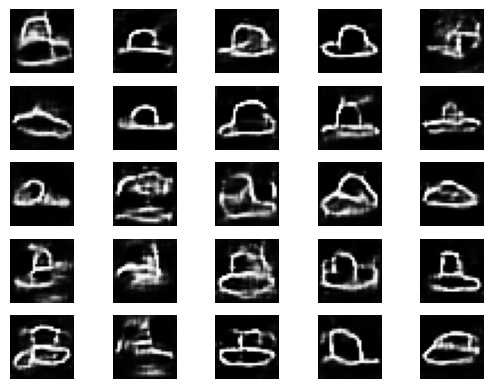

In [9]:
# probar el modelo terminado
sample_images(epoch=999)
# Escribir la funcion de ayuda para visualizar ejemplos